In [1]:
import ROOT
from os import path
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np
from statistics import mean, median
import math
from array import array
import csv
from datetime import datetime
import matplotlib.pyplot as plt



def Build_ML_Feature_Arrays_ptTrue(
    input_file_path, input_tree_name, pt_true_min, pt_true_max) :
    """
    Creates an array of all features exported from ROOT.
    Applies a cut using pT_True values between pt_true_min and pt_true_max.
    """

    input_file = None;
    if (ROOT.gSystem.AccessPathName(input_file_path)) :
        print("Input file path does not exist:", input_file)
        exit()
    else :
        input_file = ROOT.TFile.Open(input_file_path, "READ")
        print("Input file accessed successfully. Output file generated.")
    
    print("Accessing input tree...")
    input_tree = input_file.Get(input_tree_name)
    print("Input tree accessed successfully.")
    
    # Setup Arrays
    X_values_A  = []  # Array of arrays of inputs corresponding to pT_true as PYTHIA jet pT
    y_values_A  = []  # Array of targets for regression, pT_true is PYTHIA jet pT
    
    X_values_B  = []  # Array of arrays of inputs corresponding to pT_true as jet pT * PYTHIA pT / const. pT
    y_values_B  = []  # Array of targets for regression, pT_true is jet pT * PYTHIA pT / const. pT

    # Predictors
    jet_pt_raw       = None  # Raw/uncorrected jet pt
    jet_pt_corr      = None  # Corrected jet pt
    jet_mass         = None
    jet_area         = None
    jet_area_err     = None
    jet_const_n      = None
    const_pt_mean    = None  # Mean pt of jet constituents
    const_pt_median  = None  # Mean pt of jet constituents
    const_1_pt       = None  # pt of jet constituent particle 1
    const_2_pt       = None  # pt of jet constituent particle 2
    const_3_pt       = None  # pt of jet constituent particle 3
    const_4_pt       = None  # pt of jet constituent particle 4
    const_5_pt       = None  # pt of jet constituent particle 5
    const_6_pt       = None  # pt of jet constituent particle 6
    const_7_pt       = None  # pt of jet constituent particle 7
    const_8_pt       = None  # pt of jet constituent particle 8
    const_9_pt       = None  # pt of jet constituent particle 9
    const_10_pt      = None  # pt of jet constituent particle 10
    jet_y            = None
    jet_phi          = None
    jet_rho          = None

    # Targets
    jet_pt_true_A    = None  # True jet pt (determined from PYTHIA jets)
    jet_pt_true_B    = None

    # Helper Variables
    event_counter    = 0
    event_n_total    = 20000
    jet_n            = None  # Number of jets in an event
    jet_n_counter_A  = 0
    jet_n_counter_B  = 0
    jet_const_pt_arr = []    # Array of jet constituents and their values
    sc_correction_arr_A = []
    sc_correction_arr_B = []
    
    print("Preparing to collect data from tree...")

    # Collecting from TTree
    for event in input_tree :  
        jet_n = event.jet_n

        for jet in range(0, jet_n) :
            jet_pt_raw      = input_tree.jet_pt_raw[jet]
            jet_pt_corr     = input_tree.jet_pt_corr[jet]
            jet_mass        = input_tree.jet_mass[jet]
            jet_area        = input_tree.jet_area[jet]
            jet_const_n     = input_tree.jet_const_n[jet]
            const_pt_mean   = input_tree.const_pt_mean[jet]
            const_pt_median = input_tree.const_pt_median[jet]
            const_1_pt      = input_tree.const_1_pt[jet]
            const_2_pt      = input_tree.const_2_pt[jet]
            const_3_pt      = input_tree.const_3_pt[jet]
            const_4_pt      = input_tree.const_4_pt[jet]
            const_5_pt      = input_tree.const_5_pt[jet]
            const_6_pt      = input_tree.const_6_pt[jet]
            const_7_pt      = input_tree.const_7_pt[jet]
            const_8_pt      = input_tree.const_8_pt[jet]
            const_9_pt      = input_tree.const_9_pt[jet]
            const_10_pt     = input_tree.const_10_pt[jet]
            jet_y           = input_tree.jet_y[jet]
            jet_phi         = input_tree.jet_phi[jet]
            jet_rho         = input_tree.jet_rho[jet]
            
            jet_pt_true_A   = input_tree.jet_pt_true_pythia[jet]
            jet_pt_true_B   = input_tree.jet_pt_true_paper[jet]
            
            temp_jet_arr = [
                    jet_pt_raw,      jet_pt_corr,       jet_area, jet_mass, 
                        jet_const_n,     const_pt_mean,   const_pt_median, jet_rho,
                    const_1_pt,      const_2_pt,      const_3_pt,      const_4_pt,
                    const_5_pt,      const_6_pt,      const_7_pt,      const_8_pt,
                    const_9_pt,      const_10_pt,     jet_y,           jet_phi]
            
            if (jet_pt_true_A != 0.0) and (jet_pt_true_A > pt_true_min) and (jet_pt_true_A < pt_true_max) :
                X_values_A.append(temp_jet_arr)

                y_values_A.append(jet_pt_true_A)
                
                sc_correction_arr_A.append(jet_pt_corr)
                
                jet_n_counter_A   = jet_n_counter_A + 1
                
                if event_counter % 1000 == 0 : print(f"Event: {event_counter:3.0f} | Jet: {jet:2.0f} | pTraw: {jet_pt_raw:3.3f} | pTcorr: {jet_pt_corr: 3.3f} | pTtrue_A: {jet_pt_true_A: 5.3f}")
            
            if (jet_pt_true_B != 0.0) and (jet_pt_true_B > pt_true_min) and (jet_pt_true_B < pt_true_max) :
                X_values_B.append(temp_jet_arr)
                
                y_values_B.append(jet_pt_true_B)

                sc_correction_arr_B.append(jet_pt_corr)
                
                jet_n_counter_B   = jet_n_counter_B + 1

                if event_counter % 1000 == 0 : print(f"Event: {event_counter:3.0f} | Jet: {jet:2.0f} | pTraw: {jet_pt_raw:3.3f} | pTcorr: {jet_pt_corr: 3.3f} | pTtrue_B: {jet_pt_true_B: 5.3f}")
            
        event_counter += 1

    print(f"All data transferred to array. Testing with {jet_n_counter_A} A-jets and {jet_n_counter_B} B-jets.\n")
    print(f"Training set A: {len(X_values_A)} / {len(y_values_A)} / {len(sc_correction_arr_A)}")
    print(f"Training set B: {len(X_values_B)} / {len(y_values_B)} / {len(sc_correction_arr_B)}")

    input_file.Close()
    print("Input file closed.")
    
    return X_values_A, y_values_A, sc_correction_arr_A, X_values_B, y_values_B, sc_correction_arr_B

    

def Build_ML_Feature_Arrays_ptCorr(
    input_file_path, input_tree_name, pt_corr_min, pt_corr_max) :
    """
    WARNING: CODE MAY BE OUTDATED
    Creates an array of all features exported from ROOT.
    Applies a cut using pT_Corrected values between pt_corr_min and pt_corr_max.
    This was used once for an alternative selection method and may no longer work.
    """

    input_file = None;
    if (ROOT.gSystem.AccessPathName(input_file_path)) :
        print("Input file path does not exist:", input_file)
        exit()
    else :
        input_file = ROOT.TFile.Open(input_file_path, "READ")
        print("Input file accessed successfully. Output file generated.")
    
    print("Accessing input tree...")
    input_tree = input_file.Get(input_tree_name)
    print("Input tree accessed successfully.")

    # Setup Arrays
    X_values_A  = []  # Array of arrays of inputs corresponding to pT_true as PYTHIA jet pT
    y_values_A  = []  # Array of targets for regression, pT_true is PYTHIA jet pT
    
    X_values_B  = []  # Array of arrays of inputs corresponding to pT_true as jet pT * PYTHIA pT / const. pT
    y_values_B  = []  # Array of targets for regression, pT_true is jet pT * PYTHIA pT / const. pT

    # Predictors
    jet_pt_raw       = None  # Raw/uncorrected jet pt
    jet_pt_corr      = None  # Corrected jet pt
    jet_mass         = None
    jet_area         = None
    jet_area_err     = None
    jet_const_n      = None
    const_pt_mean    = None  # Mean pt of jet constituents
    const_pt_median  = None  # Mean pt of jet constituents
    const_1_pt       = None  # pt of jet constituent particle 1
    const_2_pt       = None  # pt of jet constituent particle 2
    const_3_pt       = None  # pt of jet constituent particle 3
    const_4_pt       = None  # pt of jet constituent particle 4
    const_5_pt       = None  # pt of jet constituent particle 5
    const_6_pt       = None  # pt of jet constituent particle 6
    const_7_pt       = None  # pt of jet constituent particle 7
    const_8_pt       = None  # pt of jet constituent particle 8
    const_9_pt       = None  # pt of jet constituent particle 9
    const_10_pt      = None  # pt of jet constituent particle 10
    jet_y            = None
    jet_phi          = None
    jet_rho          = None
    

    # Targets
    jet_pt_true_A    = None  # True jet pt (determined from PYTHIA jets)
    jet_pt_true_B    = None

    # Helper Variables
    event_n          = 0
    event_n_total    = 20000
    jet_n            = None  # Number of jets in an event
    jet_n_counter_A  = 0
    jet_n_counter_B  = 0
    jet_const_pt_arr = []    # Array of jet constituents and their values
    sc_correction_arr_A = []
    sc_correction_arr_B = []

    print("Preparing to collect data from tree...")
    
    # Collecting from TTree
    for event in input_tree :  
        jet_n = event.jet_n
        
        for jet in range(0, jet_n) :
            jet_pt_raw      = input_tree.jet_pt_raw[jet]
            jet_pt_corr     = input_tree.jet_pt_corr[jet]
            jet_mass        = input_tree.jet_mass[jet]
            jet_area        = input_tree.jet_area[jet]
            jet_const_n     = input_tree.jet_const_n[jet]
            const_pt_mean   = input_tree.const_pt_mean[jet]
            const_pt_median = input_tree.const_pt_median[jet]
            const_1_pt      = input_tree.const_1_pt[jet]
            const_2_pt      = input_tree.const_2_pt[jet]
            const_3_pt      = input_tree.const_3_pt[jet]
            const_4_pt      = input_tree.const_4_pt[jet]
            const_5_pt      = input_tree.const_5_pt[jet]
            const_6_pt      = input_tree.const_6_pt[jet]
            const_7_pt      = input_tree.const_7_pt[jet]
            const_8_pt      = input_tree.const_8_pt[jet]
            const_9_pt      = input_tree.const_9_pt[jet]
            const_10_pt     = input_tree.const_10_pt[jet]
            jet_y           = input_tree.jet_y[jet]
            jet_phi         = input_tree.jet_phi[jet]
            jet_rho         = input_tree.jet_rho[jet]
            
            jet_pt_true_A   = input_tree.jet_pt_true_pythia[jet]
            jet_pt_true_B   = input_tree.jet_pt_true_paper[jet]
            
            temp_jet_arr = [
                    jet_pt_raw,      jet_pt_corr,     const_pt_mean,        jet_area, 
                        jet_const_n,     jet_mass,   const_pt_median, jet_rho,
                    const_1_pt,      const_2_pt,      const_3_pt,      const_4_pt,
                    const_5_pt,      const_6_pt,      const_7_pt,      const_8_pt,
                    const_9_pt,      const_10_pt,     jet_y,           jet_phi,]
            
            if (jet_pt_true_A != 0.0) and (jet_pt_corr > pt_corr_min) and (jet_pt_corr < pt_corr_max) :
                
                X_values_A.append(temp_jet_arr)

                y_values_A.append(jet_pt_true_A)
                
                sc_correction_arr_A.append(jet_pt_corr)
                
                jet_n_counter_A   = jet_n_counter_A + 1
                
                if jet_n_counter_A % 10 == 0 :
                    print(f"Event: {event_n:3.0f} | Jet: {jet:2.0f} | pTraw: {jet_pt_raw:3.3f} | pTcorr: {jet_pt_corr: 3.3f} | pTtrue_A: {jet_pt_true_A: 5.3f}")
            
            if (jet_pt_true_B != 0.0) and (jet_pt_corr > pt_corr_min) and (jet_pt_corr < pt_corr_max) :
                X_values_B.append(temp_jet_arr)
                
                y_values_B.append(jet_pt_true_B)

                sc_correction_arr_B.append(jet_pt_corr)
                
                jet_n_counter_B   = jet_n_counter_B + 1

                if jet_n_counter_B % 10 == 0 :
                    print(f"Event: {event_n:3.0f} | Jet: {jet:2.0f} | pTraw: {jet_pt_raw:3.3f} | pTcorr: {jet_pt_corr: 3.3f} | pTtrue_B: {jet_pt_true_A: 5.3f}")

        event_n = event_n + 1

    print(f"All data transferred to array. Testing with {jet_n_counter_A} A-jets and {jet_n_counter_B} B-jets.\n")
    print(f"Training set A: {len(X_values_A)} / {len(y_values_A)} / {len(sc_correction_arr_A)}")
    print(f"Training set B: {len(X_values_B)} / {len(y_values_B)} / {len(sc_correction_arr_B)}")

    input_file.Close()
    print("Input file closed.")
    
    return X_values_A, y_values_A, sc_correction_arr_A, X_values_B, y_values_B, sc_correction_arr_B

Welcome to JupyROOT 6.26/06


In [2]:
train_directory    = "./compiled/Data/"
train_file_name    = "ML_Prep_10_90_Train.root"
train_tree_name    = "Tree_10_90_Train"
train_file_path    = train_directory + train_file_name

test_directory     = "./compiled/Data/"
test_file_names    = ["ML_Prep_40_60_Test.root"]
# test_file_names    = ["ML_Prep_40_60_Test.root"]
test_tree_names    = ["Tree_40_60_Test"]
# test_tree_names    = ["Tree_40_60_Test"]
test_file_paths    = [test_directory + test_file_names[i] for i in range(len(test_file_names))]

output_directory   = "./compiled/Data/"
output_file_name   = "ML_Results_10_90.root"
output_file_path   = output_directory + output_file_name

X_train_A, y_train_A, sc_corr_train_arr_A, X_train_B, y_train_B, sc_corr_train_arr_B = Build_ML_Feature_Arrays_ptTrue(
    train_file_path, train_tree_name, 10.0, 90.0)

now = datetime.now()
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")

print("Ready!", dt_string)

Input file accessed successfully. Output file generated.
Accessing input tree...
Input tree accessed successfully.
Preparing to collect data from tree...
Event:   0 | Jet:  4 | pTraw: 81.147 | pTcorr:  3.849 | pTtrue_A:  10.595
Event: 1000 | Jet:  7 | pTraw: 58.631 | pTcorr:  13.591 | pTtrue_A:  11.410
Event: 1000 | Jet:  7 | pTraw: 58.631 | pTcorr:  13.591 | pTtrue_B:  21.792
Event: 3000 | Jet:  1 | pTraw: 167.187 | pTcorr:  105.592 | pTtrue_B:  26.707
Event: 3000 | Jet:  2 | pTraw: 83.842 | pTcorr:  33.869 | pTtrue_A:  28.031
Event: 3000 | Jet:  2 | pTraw: 83.842 | pTcorr:  33.869 | pTtrue_B:  29.770
Event: 4000 | Jet:  1 | pTraw: 75.969 | pTcorr:  28.051 | pTtrue_A:  13.610
Event: 4000 | Jet:  1 | pTraw: 75.969 | pTcorr:  28.051 | pTtrue_B:  12.265
Event: 4000 | Jet:  3 | pTraw: 61.427 | pTcorr:  18.500 | pTtrue_A:  15.872
Event: 4000 | Jet:  3 | pTraw: 61.427 | pTcorr:  18.500 | pTtrue_B:  86.076
Event: 5000 | Jet:  0 | pTraw: 117.313 | pTcorr:  69.074 | pTtrue_A:  86.254
Event: 50

In [3]:
X_train = X_train_A
y_train = y_train_A
output_dir = "./compiled/Data"
output_fil = "results_10_90"
output_ext = ".root"
newX = []
newY = []
for i in range(len(y_train)):
    if y_train[i] > 60:
        newX.append(X_train[i])
        newY.append(y_train[i])
    elif y_train[i] > 50:
        if not np.random.uniform(0,1) < 0.2:
            newX.append(X_train[i])
            newY.append(y_train[i])
    elif y_train[i] > 40:
        if not np.random.uniform(0,1) < 0.25:
            newX.append(X_train[i])
            newY.append(y_train[i])
    elif y_train[i] > 30:
        if not np.random.uniform(0,1) < 0.45:
            newX.append(X_train[i])
            newY.append(y_train[i])
    elif y_train[i] > 20:
        if not np.random.uniform(0,1) < 0.625:
            newX.append(X_train[i])
            newY.append(y_train[i])
    else:
        if not np.random.uniform(0,1) < 0.82:
            newX.append(X_train[i])
            newY.append(y_train[i])
            

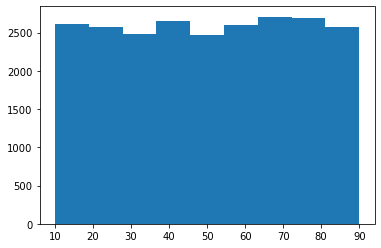

In [4]:


            
X_train = newX
y_train = newY

counts,bins = np.histogram(newY, bins=9)
plt.hist(bins[:-1], bins, weights=counts, range=(10,90))

def test(X_test, y_test, model, i):
    y_pred = model.predict(X_test)
    xmin = -49.5
    xmax = 50.5
    bins = 100
    outf = ROOT.TFile.Open(output_directory + output_fil + model.__class__.__name__ + str(len(indices)) + "Features"+ output_ext, "RECREATE")
    outt = ROOT.TTree(test_tree_names[0] + model.__class__.__name__, "tree")
    csvfile = test_tree_names[0][5:-5] + model.__class__.__name__ + ".csv"
    f = open(csvfile, "w")
    deltahist = ROOT.TH1D("hist", "Jet p_{T} Delta " + str(len(indices)) + " Feature(s) Test " + test_tree_names[0][5:-5] + " GeV (Falling) Test 10_90 GeV (Falling) Train", bins, xmin, xmax)
    deltahist.GetXaxis().SetTitle("p_{T true} - p_{T predicted}")
    deltahist.GetYaxis().SetTitle("Counts")
    deltahist.GetXaxis().SetRangeUser(-50, 50)
    deltahist.GetYaxis().SetRangeUser(0,750)
    deltahist.SetMarkerStyle(2)
    deltahist.SetMarkerColor(q)
    for j in range(len(y_test)):
        deltahist.Fill((y_pred[j] - y_test[j]))
        f.write(str((y_test[j] - y_pred[j])) + "\n")
    deltahist.SetDirectory(0)
    outf.cd()
    deltahist.Write()
    outf.Write()
    outf.Close()
    f.close()
    return 0

In [5]:
def fill_schist(corvals, truevals, i):
    xmin = -49.5
    xmax = 50.5
    bins = 100
    outf = ROOT.TFile.Open(output_directory + output_fil + "corrected" + str(len(indices)) + "Features" + output_ext, "RECREATE")
    outt = ROOT.TTree(test_tree_names[0][:-5] + " corrected", "tree")
    deltahist = ROOT.TH1D("hist", "Jet p_{T} Delta " + str(len(indices)) + " Feature(s) Test " + test_tree_names[0][5:-5] + " GeV (Falling) Test 10_90 GeV (Falling) Test", bins, xmin, xmax)
    deltahist.GetXaxis().SetTitle("p_{T true} - p_{T predicted}")
    deltahist.GetYaxis().SetTitle("Counts")
    deltahist.GetXaxis().SetRangeUser(-50, 50)
    deltahist.GetYaxis().SetRangeUser(0,750)
    deltahist.SetMarkerStyle(2)
    deltahist.SetMarkerColor(5)
    csvfile = "Correction" + str(len(indices))+ ".csv"
    f = open(csvfile, "w")
    for j in range(len(corvals)):
        deltahist.Fill((corvals[j][1] - truevals[j]))
        f.write(str((corvals[j][1]-truevals[j])))
    deltahist.SetDirectory(0)
    outf.cd()
    deltahist.Write()
    outf.Write()
    outf.Close()
    f.close()
    return 0

In [6]:
def evaluate_model(model, indices, X_test, y_test, k):
    newX_train = []
    for i in range(len(X_train)):
        ph = []
        for j in range(len(X_train[0])):
            if j in indices:
                ph.append(X_train[i][j])
        newX_train.append(ph)
    model.fit(newX_train, y_train)
    newX_test = []
    for i in range(len(X_test)):
        ph = []
        for j in range(len(X_test[0])):
            if j in indices:
                ph.append(X_test[i][j])
        newX_test.append(ph)
    test(newX_test, y_test, model, k)

In [7]:
X_test, y_test = [], []
for i in range(len(test_file_names)):
    X, y, _,_,_,_ = Build_ML_Feature_Arrays_ptTrue(test_file_paths[i], test_tree_names[i], float(test_tree_names[i][5:7]), float(test_tree_names[i][8:10]))
    X_test.append(X)
    y_test.append(y)


Input file accessed successfully. Output file generated.
Accessing input tree...
Input tree accessed successfully.
Preparing to collect data from tree...
Event:   0 | Jet:  1 | pTraw: 96.591 | pTcorr:  40.570 | pTtrue_A:  44.418
Event: 1000 | Jet:  0 | pTraw: 127.041 | pTcorr:  62.934 | pTtrue_A:  50.561
Event: 1000 | Jet:  0 | pTraw: 127.041 | pTcorr:  62.934 | pTtrue_B:  50.218
Event: 2000 | Jet:  1 | pTraw: 83.666 | pTcorr:  42.828 | pTtrue_A:  41.361
Event: 2000 | Jet:  1 | pTraw: 83.666 | pTcorr:  42.828 | pTtrue_B:  46.498
Event: 3000 | Jet:  0 | pTraw: 104.061 | pTcorr:  45.029 | pTtrue_A:  57.471
Event: 3000 | Jet:  0 | pTraw: 104.061 | pTcorr:  45.029 | pTtrue_B:  57.085
Event: 4000 | Jet:  0 | pTraw: 103.319 | pTcorr:  50.241 | pTtrue_A:  53.634
Event: 4000 | Jet:  0 | pTraw: 103.319 | pTcorr:  50.241 | pTtrue_B:  52.904
Event: 5000 | Jet:  0 | pTraw: 113.734 | pTcorr:  51.171 | pTtrue_A:  51.882
Event: 5000 | Jet:  0 | pTraw: 113.734 | pTcorr:  51.171 | pTtrue_B:  51.541
Eve

In [8]:
indices = [[0,1,2,3,4,5,6,7,8,9,10,11]]
indices.append([0,1,2])
indices.append([0])
lr = LinearRegression()
rf = RandomForestRegressor()
nn = MLPRegressor()
q=2
for i in range(len(indices)):
    evaluate_model(lr, indices[i], X_test[0], y_test[0],i)
    q += 1
    evaluate_model(rf, indices[i], X_test[0], y_test[0],i)
    q += 1
    evaluate_model(nn, indices[i], X_test[0], y_test[0],i)
    fill_schist(X_test[0], y_test[0], i)

/home/qq/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
